# ADA PROJECT - Amazon data

Collection/Analysis of data from Amazon (Reviews and Metadata of products) associated to the thema : ecology, bio, renewable etc... (see keywords vector)

<br>

__Review data__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'reviews' file for a 
chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)

>Features:
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

__Metadata (Product)__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'metadata' file for a chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)


>Features:
- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to



---

### TO DO LIST

In the followings statements, 'extracted' means filtered with the thema : products/reviews associated to bio/ecology/renewable etc...

- Choose category to focus on : Books ?  / Cinema Movies / Kindle Store / Home Kitchen / Health Personal Care (K) / Tools Home Improvement (K) / Grocery Food  / Tools Home (K)
- Show Proportion of extracted data compared to the full data (of the category)
- Comparison of extracted data between categories (which one contains the most related products/review interest)
- Distribution Price of extracted data (per category) --> Compare between category and with not extracted data in the same category
- Distribution salesRank of extracted data (best per category, mean, proportion of 10% first, 20%first etc...) --> Compare between category and with not extracted data in the same category

- __Keywords__ : How to efficiently implement the selection of related data ? Currently with a list of key words, can use regexp, better writing of keywords etc.. ?

- Associate Metadata with Reviews : __Join__
> - Extract year of 1st review (which will give the publication year of the product -approximately-)
> - Histograms number of extracted products per year 
> - Histograms number of extracted reviews per year
> - Nb of reviews per product per category --> Distribution, compare between categories and with not extracted data to see if reviewers are more inerested/active with our thema products compared to others
> - Helplful note : Compare between categories / Overall
> - Mean rating product : Compare with other products


- __Prediction__
> - Nb of products for following years (Linear Regression)
> - Sentiment Analysis on Reviews (Experiment ?)
> - Prediction overall on price for following years ? (LR)



---
### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from datetime import datetime



%matplotlib inline

In [2]:
import findspark
findspark.init()
import pyspark

from pyspark.sql.types import DateType
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql import SQLContext
import pyspark.sql.functions as sqlf

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

<br>



---
### Data collection and preprocessing

<br>

**Grocery and Gourmet Food**

In [ ]:
%run -i "data_collection_grocery_food"
# Run the # Run the data_collection_grocery_food.py file .py file 

**Healthcare**

In [ ]:
%run -i "data_collection_healthcare"

**Patio Lawn and Garden**

In [ ]:
%run -i "data_collection_lawn_garden"

**Books**

In [ ]:
%run -i "data_collection_books"

<br>

---
### Loading data
<br>

**Grocery and Gourmet Food**

In [ ]:
grocery_food_datacleaned = spark.read.parquet("meta_Grocery_and_Gourmet_Food.parquet")
grocery_food_reviews = spark.read.parquet("reviews_Grocery_and_Gourmet_Food.parquet")
grocery_food_review_product_join = spark.read.parquet("Grocery_and_Gourmet_Food.parquet")

In [ ]:
grocery_filter_products_bio = grocery_food_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Healthcare**

In [ ]:
healthcare_datacleaned = spark.read.parquet("meta_HealthPersonalCare.parquet")
healthcare_reviews = spark.read.parquet("reviews_HealthPersonalCare.parquet")
healthcare_review_product_join = spark.read.parquet("HealthPersonalCare_joined.parquet")

In [ ]:
healthcare_filter_products_bio = healthcare_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Patio Lawn and Garden**

In [ ]:
patiolawn_garden_datacleaned = spark.read.parquet("meta_PatioLawnGarden.parquet")
patiolawn_garden_reviews = spark.read.parquet("reviews_PatioLawnGarden.parquet")
patiolawn_garden_review_product_join = spark.read.parquet("PatioLawnGarden_joined.parquet")

In [ ]:
patiolawn_garden_filter_products_bio = patiolawn_garden_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Books**

In [3]:
books_datacleaned = spark.read.parquet("meta_Books.parquet")
books_reviews = spark.read.parquet("reviews_Books.parquet")
books_review_product_join = spark.read.parquet("joined_Books.parquet")

In [4]:
books_filter_products_bio = books_datacleaned.rdd.filter(lambda r: (r[5] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[5].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

<br>

---
### Analysis

<br>

Useful functions:

In [8]:
keywords = [" global warming", " solar energy", " recycling ", " pollution ", "solar power", " endangered species", "air pollution", \
" water pollution", " wind energy", " climate change", " wind power", " recycle ", " deforestation", " greenhouse effect", "environment", \
" sustainability ", " natural resources", "alternative energy", " climate ", "global warming", "renewable energy", " ecology", "composting", \
" carbon footprint", " bio ", " biosphere ", " renewable "]

<br>

**1) Grocery and Gourmet Food**

In [ ]:
print("GROCERY FOOD : Number of products : " + str(grocery_food_datacleaned.rdd.count()) )
print("GROCERY FOOD : Number of products related to ecology/bio/renewable etc... : " + str(grocery_filter_products_bio.count()) )

Proportion of extracted data related to ecology/bio/renewable compared to the full data that was available:

In [ ]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([grocery_food_filter_products_bio.count(), grocery_food_datacleaned.rdd.count()-grocery_food_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('Grocery and Gourmet Food data'); plt.axis('equal'); plt.show()

Let's take a look at one entry that was extracted:

In [ ]:
grocery_food_filter_products_bio.take(1)

**2) Healthcare**

In [ ]:
print("HEALTHCARE : Number of products : " + str(healthcare_datacleaned.rdd.count()) )
print("HEALTHCARE : Number of products related to ecology/bio/renewable etc... : " + str(healthcare_filter_products_bio.count()) )

In [ ]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([healthcare_filter_products_bio.count(), healthcare_datacleaned.rdd.count()-healthcare_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('Healthcare data'); plt.axis('equal'); plt.show()

**3) Patio Lawn and Garden**

In [ ]:
print("PATIOLAWN - GARDEN : Number of products : " + str(patiolawn_garden_datacleaned.rdd.count()) )
print("PATIOLAWN - GARDEN : Number of products related to ecology/bio/renewable etc... : " + str(patiolawn_garden_filter_products_bio.count()) )

In [ ]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([patiolawn_garden_filter_products_bio.count(), patiolawn_garden_datacleaned.rdd.count()-patiolawn_garden_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('PatioLawn Garden data'); plt.axis('equal'); plt.show()

**4) Books**

In [9]:
print("BOOKS : Number of products : " + str(books_datacleaned.rdd.count()) )
print("BOOKS : Number of products related to ecology/bio/renewable etc... : " + str(books_filter_products_bio.count()) )

BOOKS : Number of products : 2370585
BOOKS : Number of products related to ecology/bio/renewable etc... : 20723


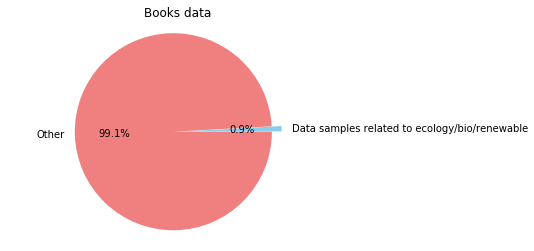

In [10]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([books_filter_products_bio.count(), books_datacleaned.rdd.count()-books_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('Books data'); plt.axis('equal'); plt.show()

<br>
<br>

__Let's see the evolution of the trend in products by year:__


**1) Grocery and Gourmet Food**

In [ ]:
grocerybio_firstrev = grocery_food_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
grocerybio_firstrev_pd = grocerybio_firstrev.toPandas()
grocerybio_firstrev_pd['Year'] = pd.to_datetime(grocerybio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

groceryall_firstrev = grocery_food_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
groceryall_firstrev_pd = groceryall_firstrev.toPandas()
groceryall_firstrev_pd['Year'] = pd.to_datetime(groceryall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16,4)


grocery_firstrev_pd.hist("Year", color="skyblue", log=True,bins=10,ax=axes[0])
plt.title('Evolution of the trend in the products')


globalyear_reviews_Pandas.hist("Year", log=True, color="skyblue", bins=14, ax=axes[1])
plt.title('Evolution of the trend in the reviews')

plt.show()

**2) Healthcare**

In [ ]:
healthcarebio_firstrev = healthcare_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
healthcarebio_firstrev_pd = healthcarebio_firstrev.toPandas()
healthcarebio_firstrev_pd['Year'] = pd.to_datetime(healthcarebio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

healthcareall_firstrev = healthcare_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
healthcareall_firstrev_pd = healthcareall_firstrev.toPandas()
healthcareall_firstrev_pd['Year'] = pd.to_datetime(healthcareall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16,4)


healthcarebio_firstrev_pd.hist("Year", color="skyblue", log=True,bins=10,ax=axes[0])
plt.title('Evolution of the trend in the products')


healthcareall_firstrev_pd.hist("Year", log=True, color="skyblue", bins=14, ax=axes[1])
plt.title('Evolution of the trend in the reviews')

plt.show()

**3) PatioLawn Garden**

In [ ]:
gardenbio_firstrev = patiolawn_garden_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
gardenbio_firstrev_pd = gardenbio_firstrev.toPandas()
gardenbio_firstrev_pd['Year'] = pd.to_datetime(gardenbio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

gardeneall_firstrev = patiolawn_garden_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
gardeneall_firstrev_pd = gardeneall_firstrev.toPandas()
gardeneall_firstrev_pd['Year'] = pd.to_datetime(gardeneall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16,4)


gardenbio_firstrev_pd.hist("Year", color="skyblue", log=True,bins=10,ax=axes[0])
plt.title('Evolution of the trend in the products')


gardeneall_firstrev_pd.hist("Year", log=True, color="skyblue", bins=14, ax=axes[1])
plt.title('Evolution of the trend in the reviews')

plt.show()

**4) Books**

In [ ]:
booksbio_firstrev = books_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
booksbio_firstrev_pd = booksbio_firstrev.toPandas()
booksbio_firstrev_pd['Year'] = pd.to_datetime(booksbio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

booksall_firstrev = books_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
booksall_firstrev_pd = booksall_firstrev.toPandas()
booksall_firstrev_pd['Year'] = pd.to_datetime(booksall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16,4)


booksall_firstrev_pd.hist("Year", color="skyblue", log=True,bins=10,ax=axes[0])
plt.title('Evolution of the trend in the products')


booksall_firstrev_pd.hist("Year", log=True, color="skyblue", bins=14, ax=axes[1])
plt.title('Evolution of the trend in the reviews')

plt.show()

<br>

Let's now see distribution of reviews per products for each of the categories:

**1) Grocery Food**

In [ ]:
grocerybio_nbrev_perproduct=  grocery_food_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [ ]:
grocerybio_nbreviews_DF = spark.createDataFrame(grocerybio_nbrev_perproduct, ['productID','freq'])

In [ ]:
grocerybio_nbreviews_Pandas = nbreviews_DF.toPandas()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
grocerybio_nbreviews_Pandas.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

**2) Healthcare**

In [ ]:
healthcarebio_nbrev_perproduct=  healthcare_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [ ]:
healthcarebio_nbreviews_DF = spark.createDataFrame(healthcarebio_nbrev_perproduct, ['productID','freq'])

In [ ]:
healthcarebio_nbreviews_pd = healthcarebio_nbreviews_DF.toPandas()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
healthcarebio_nbreviews_pd.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

**3) Patio Lawn Garden**

In [ ]:
gardenbio_nbrev_perproduct=  patiolawn_garden_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [ ]:
gardenbio_nbreviews_DF = spark.createDataFrame(gardenbio_nbrev_perproduct, ['productID','freq'])

In [ ]:
gardenbio_nbreviews_pd = gardenbio_nbreviews_DF.toPandas()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
gardenbio_nbreviews_pd.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

In [ ]:
gardenall_nbrev_perproduct=  patiolawn_garden_reviews.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [ ]:
gardenall_nbreviews_DF = spark.createDataFrame(gardenall_nbrev_perproduct, ['productID','freq'])

In [ ]:
gardenall_nbreviews_pd = gardenall_nbreviews_DF.toPandas()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
gardenall_nbreviews_pd.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

<br>

---
### Predictions

<br>